In [1]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")


import src.my_functions_product1 as myFC
import matplotlib.pyplot as plt

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


## Inputting from the user

In [2]:
# reading the file from a path and list the field names and input columns of interest

#path = 'Data/adult/'
#data_filename = 'adult.data'

path = 'Data/bank/'
data_filename = 'bank.csv'

#####path = 'data/compas.csv'

X_df, Ybin, Zbin, result_fname = myFC.read_process_data_output_bias(path+data_filename)

Columns in your data are:
  ['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'duration' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']
Your possible target columns '{'previous', 'loan', 'emp.var.rate', 'pdays', 'cons.conf.idx', 'poutcome', 'default', 'education', 'day_of_week', 'age', 'job', 'marital', 'campaign', 'y', 'housing', 'month', 'nr.employed', 'cons.price.idx', 'contact', 'duration', 'euribor3m'}'
Which column is your target column?:y
Your target column is 'y'
-----------------------------------

Do you have any column for your current prediction? Please enter Y or N:N
Do you have any column for your current prediction? You entered'N'
-----------------------------------

Your prediction column possible values '{'yes', 'no'}'
Please enter two different labels in the target field: 
Enter label 0:no
Your target label 0 is 'no'
---------------------------------

## Feature Creation

In [3]:
X_train, X_test, y_train, y_test, Z_train, Z_test = myFC.feature_creation(X_df, Ybin, Zbin)

## Setting up default architectures

In [4]:
n_features = X_train.shape[1]
main_task_arch_json_string, adv_task_arch_json_string = myFC.Default_main_task_adv_architecture(n_features)

## Model and compile only main task: check prediction results

In [5]:
# no weights provided by the user, we will save the file
h5_file_name = path + 'new_h5_file_trained_here.h5'
save_the_weights = True

result_fname = path + 'Trade-off-results/'

main_task_accuracy, p_rule_for_Y1, y_pred = myFC.pre_train_main_task(main_task_arch_json_string,X_train, y_train,X_test,y_test,Z_test,save_the_weights=save_the_weights,h5_file_name=h5_file_name)



Accuracy: 90.96


## Combining the main task arch with the adversarial arch

### Train using pre-trained weights of main model

In [33]:
tradeoff_lambda_v = [12,15,20] 
pre_load_flag = True

main_task_trained_weight_file = h5_file_name#'main_task_ori_trained_model.h5'

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)
    # initialise FairClassifier
    clf = myFC.FairClassifier(tradeoff_lambda=tradeoff_lambda,
                     main_task_arch_json_string=main_task_arch_json_string,
                     adv_task_arch_json_string=adv_task_arch_json_string,
                     pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    
    # pre-train both adverserial and classifier networks
    clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5,pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    # adverserial train on train set and validate on test set
    clf.fit(X_train, y_train, Z_train, 
            validation_data=(X_test, y_test, Z_test),
            T_iter=165, save_figs=create_gif)
    after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred = myFC.bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = myFC.saving_performance_result(before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred, after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred,tradeoff_lambda,result_fname)




tradeoff_lambda =  12
Accuracy: 90.96
Accuracy: 90.04
tradeoff_lambda =  15
Accuracy: 90.96
Accuracy: 89.88
tradeoff_lambda =  20
Accuracy: 90.96
Accuracy: 89.45


# Reading the result files

### Accuracy & p-score trade-off curves

In [39]:
tradeoff_lambda_v = [0,1,2,3,4,5,6,12] 

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = result_fname +'Result_acc_p_BA_' + 'L'+ str(tradeoff_lambda)+'.txt'
    #result_fname_acc_p_before_after = './Trade-off-results/'+result_fname_acc_p_before_after
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')

    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap

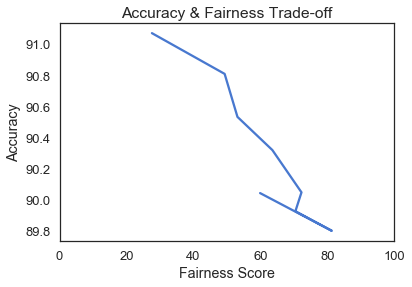

In [48]:
demo = 'one_'
fname = demo+'Trade'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
#plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')



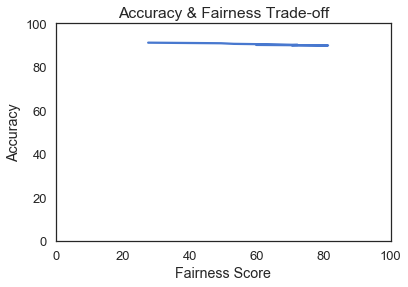

In [49]:
fname = demo+'Trade-off-zoomout'
plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('Fairness Score')
plt.ylabel('Accuracy')
plt.title('Accuracy & Fairness Trade-off')
plt.xlim(0,100)
plt.ylim(0,100)
plt.savefig(fname, bbox_inches='tight')



#### Before & After Results

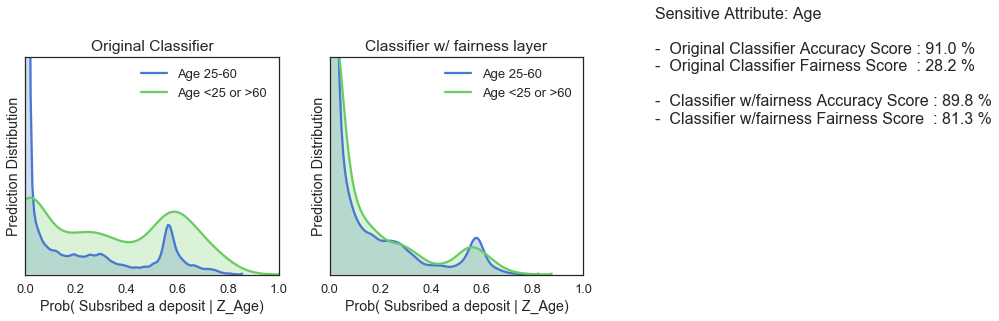

In [53]:
sensitive_class0 = 'Age 25-60'
sensitive_class1 = 'Age <25 or >60'
sensitive_field = 'Age'
good_outcome = 'Subsribed a deposit'
fname = demo+sensitive_field+good_outcome+'.png'
which_result = 6

tradeoff_lambda = tradeoff_lambda_v[which_result]
result_fname_y_pred_before_after = result_fname + 'Result_y_pred_'+'L' + str(tradeoff_lambda) +'.txt'
BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)


# without adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[0])

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[0])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Original Classifier")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))

# with adversarial training
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class0),ax=axes[1])

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format(sensitive_class1),ax=axes[1])
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_yticks([])
ax.set_title("Classifier w/ fairness layer")#.format(sensitive_field))
ax.set_ylabel('Prediction Distribution')
ax.set_xlabel('Prob( {} | Z_{})'.format(good_outcome,sensitive_field))


fig.text(1.0, 0.65, ''.join([f"Sensitive Attribute: {sensitive_field}\n\n",
                                       f"-  Original Classifier Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,0]:.1f} %\n",
                                       f"-  Original Classifier Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,1]:.1f} %\n\n",
                                       f"-  Classifier w/fairness Accuracy Score : {100*Bacc_Bp_Aacc_Ap_results[which_result,2]:.1f} %\n",
                                       f"-  Classifier w/fairness Fairness Score  : {Bacc_Bp_Aacc_Ap_results[which_result,3]:.1f} %"]),
                 fontsize='16')

plt.savefig(fname, bbox_inches='tight')

### y_pred distribution curves

In [41]:
result_fname_y_pred_before_after = result_fname + 'Result_y_pred_'+'L' + str(tradeoff_lambda) +'.txt'
#result_fname_y_pred_before_after = './Trade-off-results/'+ result_fname_y_pred_before_after

BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

#### Before the de-biaser

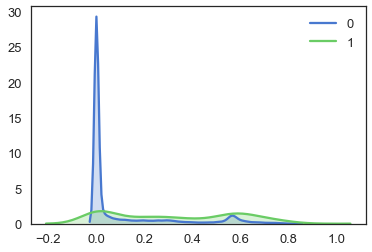

In [42]:
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))

#### After the de-biaser

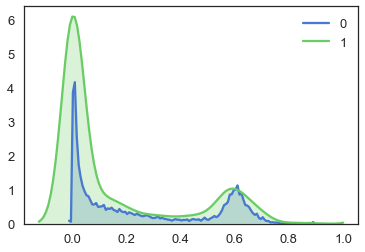

In [43]:
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))